# Learning Problem
In this notebook we will explore various machine learning models and techniques to classify image data from the Animals-10 dataset (https://www.kaggle.com/datasets/alessiocorrado99/animals10?resource=download). First, we will test a naive approach of training a deep convolutional neural network from scratch, with no preprocessing on the data. Then, we will explore more advanced techniques such as transfer learning, data augmentation, and weighted loss functions. Overall, our goal is to see how big of an improvement we can achieve in terms of accuracy by incorporating different data preprocessing techniques and architechtural changes.

## Part 1: Convolutional Neural Network from Scratch

In [ ]:
!pip install lightning
!pip install torchmetrics
!pip install onnx onnxscript onnxruntime

In [ ]:
import torch
from typing import Tuple
from torch.utils.data import DataLoader, Subset
from lightning import LightningModule
from torch import nn, Tensor
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
from lightning.pytorch import Trainer, seed_everything

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/animals-10/'

Mounted at /content/drive


In [ ]:
# Dictionary to translate italian labels to english
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

First we will develop a deep Conv2d from scratch. We will resize the images to 128x128 and use half of the data from the dataset due to computational constraints.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

dataset.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

Train and validation/test dataloaders:

In [ ]:
indices = np.random.choice(len(dataset), size=len(dataset)//2, replace=False)
dataset_small = Subset(dataset, indices)

train_size = int(0.8 * len(dataset_small))
test_size = len(dataset_small) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_small, [train_size, test_size])


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Display one of the images:

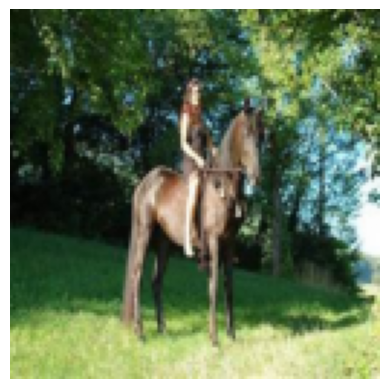

In [ ]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[0])

We use lightning module to build the model:

In [ ]:
class BaseModel(LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.accuracy = torchmetrics.classification.Accuracy(
            task="multiclass",
            num_classes=num_classes)
        self.model = self.build_model()

    def build_model(self):
        raise Exception("Not yet implemented")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        return self.model(x)

    def loss(self, logits, target):
        return nn.functional.cross_entropy(logits, target)

    def shared_step(self, mode:str, batch:Tuple[Tensor, Tensor], batch_index:int):
        x, target = batch
        output = self.forward(x)
        loss = self.loss(output, target)
        acc = self.accuracy(output, target)
        self.log(f"{mode}_loss", loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log(f"{mode}_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_index):
        return self.shared_step('train', batch, batch_index)

    def validation_step(self, batch, batch_index):
        return self.shared_step('val', batch, batch_index)

    def test_step(self, batch, batch_index):
        return self.shared_step('test', batch, batch_index)

In [ ]:
class DeepConvNet(BaseModel):
    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(3, 8, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 4, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear((32*32*4), self.num_classes)
        )

In [ ]:
model = DeepConvNet(len(dataset.classes))

Training the DeepConv2D:

In [ ]:
trainer = Trainer(
    max_epochs=3,
    accelerator="cpu",
    deterministic=False
)
trainer.fit(model,
            train_dataloaders=train_loader,
            val_dataloaders=test_loader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential         │ 42.4 K │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 42.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 42.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 10                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


The deep Conv2D from scratch only reached \~40% accuracy. Still much better than randomly guessing (\~10% accuracy), but far from ideal. Next we will use a small pretrained model and fine-tune the final layer.

## Part 2: Pretrained model MobileNetv3

In [ ]:
deepconvnet_path = "/content/drive/My Drive/deepconvnet_animals10.pth"
torch.save(model.state_dict(), deepconvnet_path)
print(f"Model saved to {deepconvnet_path}")

Model saved to /content/drive/My Drive/deepconvnet_animals10.pth


We will be using the pretrained model MobileNetV3, small version

In [ ]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

pretrained_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

This model expects a (224 x 224) dimension image, so we will need to remake the data loader.

In [ ]:
# change image size to (224, 224) since mobile net accepts that size
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# remake the loader to use the full dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Here we use lightning module to define the model. In the init function, we remove gradient tracking in all layers except the final layer, which will have 10 outputs, 1 for each animal classification.

In [ ]:
class MobileNetV3Classifier(LightningModule):
  def __init__(self, num_classes):
    super().__init__()

    self.model = pretrained_model

    for param in self.model.parameters():
      param.requires_grad = False

    num_features = self.model.classifier[-1].in_features
    self.model.classifier[-1] = nn.Linear(num_features, num_classes)

    self.criterion = nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.classification.Accuracy(
        task="multiclass",
        num_classes=num_classes,
    )

    self.train_losses = []
    self.val_losses = []
    self.train_accs = []
    self.val_accs = []

  def forward(self, x):
    return self.model(x)

  def shared_step(self, batch):
    x, y = batch
    logits = self(x)
    loss = self.criterion(logits, y)
    acc = self.accuracy(logits, y)
    return loss, acc

  def training_step(self, batch, batch_idx):
    loss, acc = self.shared_step(batch)
    self.log("train_loss", loss, prog_bar=True)
    self.log("train_acc", acc, prog_bar=True)
    return {"loss": loss, "acc": acc}

  def validation_step(self, batch, batch_idx):
    loss, acc = self.shared_step(batch)
    self.log("val_loss", loss, prog_bar=True)
    self.log("val_acc", acc, prog_bar=True)
    return {"val_loss": loss, "val_acc": acc}

  def on_train_epoch_end(self):
    outputs = self.trainer.callback_metrics
    self.train_losses.append(outputs["train_loss"].item())
    self.train_accs.append(outputs["train_acc"].item())

  def on_validation_epoch_end(self):
    outputs = self.trainer.callback_metrics
    self.val_losses.append(outputs["val_loss"].item())
    self.val_accs.append(outputs["val_acc"].item())

  def configure_optimizers(self):
    return torch.optim.Adam(
      filter(lambda p: p.requires_grad, self.parameters()),
      lr=1e-3,
    )


This time we acheived a much better accuracy (\~92%), with a much shorter training time as well.

In [ ]:
trainer = Trainer(max_epochs=3, accelerator="auto")
pretrained_model = MobileNetV3Classifier(num_classes=len(dataset.classes))
trainer.fit(pretrained_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ MobileNetV3        │  1.5 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ accuracy  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 10.2 K                                                                                           
Non-trainable params: 1.5 M                                                                                        
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 211                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


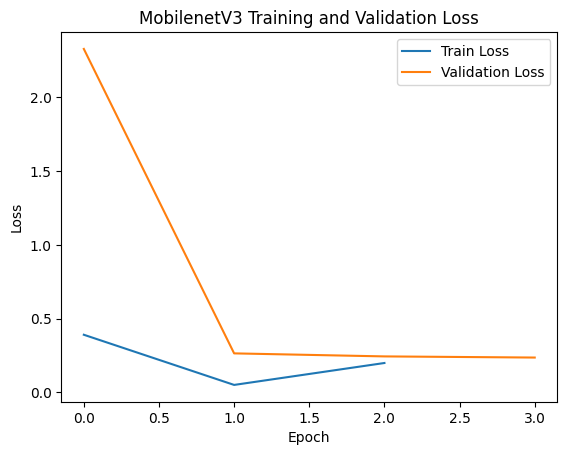

In [ ]:
plt.plot(pretrained_model.train_losses, label="Train Loss")
plt.plot(pretrained_model.val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobilenetV3 Training and Validation Loss")
plt.show()

We will export this model using onnx, since there is support for using this model type in JavaScript.

In [ ]:
import torch.onnx as onnx

onnx_path = "/content/drive/My Drive/mobilenetv3_animals10.onnx"
input_dim = torch.randn(1, 3, 224, 224)

pretrained_model.eval()
pretrained_model.cpu()

torch.onnx.export(
    pretrained_model,
    input_dim,
    onnx_path,
    export_params=True,
    opset_version=18,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"]
)
print(f"Saved ONNX model to: {onnx_path}")

[torch.onnx] Obtain model graph for `MobileNetV3Classifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV3Classifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 68 of general pattern rewrite rules.
Saved ONNX model to: /content/drive/My Drive/mobilenetv3_animals10.onnx


Save the translated class names:

In [ ]:
import json

labels_path = "/content/drive/My Drive/class_labels.json"

classnames = [translate.get(italian_name) for italian_name in dataset.classes]

with open(labels_path, "w") as f:
  json.dump(classnames, f)

print(f"Saved class names to: {labels_path}")

Saved class names to: /content/drive/My Drive/class_labels.json


## Part 3: Data Augmentation & Weighted Loss with Pretrained Model ResNet

Now we will expirement with more pretrained models and data preprocessing techniques to see how far we can go with improving the accuracy of the model.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sachmilan","key":"a85b6721e1a2bbb18c6bc9de9307af0a"}'}

In [ ]:
!mkdir -p ~/.kaggle


In [ ]:
!mv kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10


Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 96% 561M/586M [00:01<00:00, 290MB/s]
100% 586M/586M [00:03<00:00, 174MB/s]


In [ ]:
# @title
!unzip animals10.zip -d animals10


In [ ]:
import os # we need this(python) to open the files and stuff

In [ ]:
root_dir = "animals10/raw-img/" #the path for the main picture folder
classes = sorted(os.listdir(root_dir)) #sorting the list(getting the contents of the folder with the os command)
print("Classes:", classes)

# The folders(labels) are in Italian




Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [ ]:
from PIL import Image


In [ ]:
bad_images = []

for cls in classes: #we are going through the classes list
  cls_path= os.path.join(root_dir,cls)#joining it the name of each subfolder with the main path to create a paht for the sub folder
  for image in os.listdir(cls_path):# listing everything inside that specific subfolder
    image_path= os.path.join(cls_path,image)# making the path for the images
    try:
      with Image.open(image_path) as img:
        img.verify()
    except Exception as e:
      bad_images.append(image_path)

print("Number of wrong images: ", len(bad_images))
if len(bad_images)>0:
  bad_images[:10]

Number of wrong images:  0


In [ ]:
from collections import Counter # this is to count the image of a specific size

In [ ]:
#checking if the images have right resolution, otherwise it can negatively effect the model

size_counter = Counter()
too_small=[]

min_size= 64

for cls in classes: #we are going through the classes list
  cls_path= os.path.join(root_dir,cls)#joining it the name of each subfolder with the main path to create a paht for the sub folder
  for image in os.listdir(cls_path):# listing everything inside that specific subfolder
    image_path= os.path.join(cls_path,image)# making the path for the images
    try:
      with Image.open(image_path) as img:
        w,h = img.size #this returns a tupple
        size_counter[(w,h)]+=1
        if min(w,h)<min_size:
          too_small.append((image_path,(w,h)))
    except:
      pass

print("Total different sizes:", len(size_counter) )
print("Example sizes", list(size_counter.items())[:10])#size_counter is basically a dictionary object, so first we retrieved key value pairs and then we parsed them into list and then printed the first 10
if len(too_small)>0:
  len(too_small)


Total different sizes: 1002
Example sizes [((169, 300), 108), ((300, 225), 4397), ((300, 224), 110), ((300, 200), 3281), ((225, 300), 490), ((287, 300), 31), ((300, 187), 64), ((300, 207), 99), ((300, 278), 43), ((300, 199), 586)]


In [ ]:
#checking the number of images each folder has, is one category have too many, then the model can becaome biased

class_counts={}

for cls in classes:
  cls_path = os.path.join(root_dir,cls)
  class_counts[cls]= len(os.listdir(cls_path))

class_counts

{'cane': 4863,
 'cavallo': 2623,
 'elefante': 1446,
 'farfalla': 2112,
 'gallina': 3098,
 'gatto': 1668,
 'mucca': 1866,
 'pecora': 1820,
 'ragno': 4821,
 'scoiattolo': 1862}

Now we checked the contents of each folder, we have noticed that the cane(dog) is in really high percentage than most of the other animals, and so is gallina(hens) and ragno(spiders).

If we used this data to train our model then it would not train properly because it gonna prefer cane(dog), gallina(hen) and ragno(spiders) over the other animals.

So how can we fix this?

Well in order to fix this, we can use various techiques. But I will show you two most famous ones.

1. Data augmentation(DA)
2. Weighted loss function

But first let me explain what they are, and how we will use them.

Data augmentation- With this technique, we will create some extra fake images, by transforming existing one, to compensate the imbalance. Now the question is, how we gonna do it? To answer this we can do random crops, random flips, slight rotations, change the brightness/contrast a bit or slight zooms.

Weighted loss function- With this technique, we give more importance(weight) to minority classes in the loss function. for example if the cane(dog) have 4863 images and elefante(elephent) has 1446 images we give higher weight to elephent errors than dog errors. In this way missclassifying an elephant hurts more than a dog.

In [ ]:
import random #to randomize
import shutil #to copy, delete entire folders or files
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [ ]:
root_dir = "animals10/raw-img"
base_output = "data"  # new root for split data

splits = ["train", "val", "test"]
split_ratios = [0.7, 0.15, 0.15]  # 70% / 15% / 15%

# 1. Create folders
for split in splits:
    for cls in os.listdir(root_dir):
        src_cls_path = os.path.join(root_dir, cls)
        dst_dir = os.path.join(base_output, split, cls)
        os.makedirs(dst_dir, exist_ok=True)

# 2. For each class, shuffle files and copy into splits
random.seed(42)  # for reproducibility

for cls in os.listdir(root_dir):
    cls_path = os.path.join(root_dir, cls)

    files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    random.shuffle(files)

    n_total = len(files)
    n_train = int(split_ratios[0] * n_total)
    n_val   = int(split_ratios[1] * n_total)
    # rest go to test
    n_test  = n_total - n_train - n_val

    train_files = files[:n_train]
    val_files   = files[n_train:n_train + n_val]
    test_files  = files[n_train + n_val:]

    for fname in train_files:
        src = os.path.join(cls_path, fname)
        dst = os.path.join(base_output, "train", cls, fname)
        shutil.copy2(src, dst)

    for fname in val_files:
        src = os.path.join(cls_path, fname)
        dst = os.path.join(base_output, "val", cls, fname)
        shutil.copy2(src, dst)

    for fname in test_files:
        src = os.path.join(cls_path, fname)
        dst = os.path.join(base_output, "test", cls, fname)
        shutil.copy2(src, dst)

print("Done splitting!")


Done splitting!


**Data Augmentation**
- We will use ResNet18.


In [ ]:
image_size = 224  # standard for ResNet

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    ),
])

# For val/test: NO heavy augmentation, only resize+center+normalize
val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [ ]:
data_dir = "data"

train_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, "train"),
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, "val"),
    transform=val_test_transform
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(data_dir, "test"),
    transform=val_test_transform
)

print("Classes (class_to_idx):", train_dataset.class_to_idx)
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)


Classes (class_to_idx): {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
Number of classes: 10


In [ ]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,      # VERY important for training
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace final fully connected layer
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

model = resnet.to(device)

criterion = nn.CrossEntropyLoss()  # NO weights for Model 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)           # forward pass
        loss = criterion(outputs, labels) # compute loss

        loss.backward()                   # backprop
        optimizer.step()                  # update weights

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # no gradients in eval
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
num_epochs = 5  # start small; you can increase later

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


Epoch 1/5
  Train Loss: 0.2656 | Train Acc: 0.9228
  Val   Loss: 0.1411 | Val   Acc: 0.9513
Epoch 2/5
  Train Loss: 0.1077 | Train Acc: 0.9684
  Val   Loss: 0.1376 | Val   Acc: 0.9549
Epoch 3/5
  Train Loss: 0.0712 | Train Acc: 0.9780
  Val   Loss: 0.1295 | Val   Acc: 0.9602
Epoch 4/5
  Train Loss: 0.0600 | Train Acc: 0.9818
  Val   Loss: 0.1446 | Val   Acc: 0.9541
Epoch 5/5
  Train Loss: 0.0426 | Train Acc: 0.9872
  Val   Loss: 0.1930 | Val   Acc: 0.9408


In [ ]:
test_loss, test_acc = eval_one_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Test Loss: 0.2211 | Test Acc: 0.9367


**Model 2(DA+ class- weighted Loss)**

In [ ]:
from collections import Counter

label_counts = Counter(train_dataset.targets)
print("Label counts (by index):", label_counts)

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
print("Index to class mapping:", idx_to_class)


Label counts (by index): Counter({0: 3404, 8: 3374, 4: 2168, 1: 1836, 3: 1478, 6: 1306, 9: 1303, 7: 1274, 5: 1167, 2: 1012})
Index to class mapping: {0: 'cane', 1: 'cavallo', 2: 'elefante', 3: 'farfalla', 4: 'gallina', 5: 'gatto', 6: 'mucca', 7: 'pecora', 8: 'ragno', 9: 'scoiattolo'}


Rarer class = higher weight

Common class = lower weight




In [ ]:
import torch

num_classes = len(train_dataset.classes)

counts = torch.zeros(num_classes, dtype=torch.float)
for idx, c in label_counts.items():
    counts[idx] = c

total_samples = counts.sum()

class_weights = total_samples / (num_classes * counts)

print("Class counts:", counts)
print("Class weights:", class_weights)


Class counts: tensor([3404., 1836., 1012., 1478., 2168., 1167., 1306., 1274., 3374., 1303.])
Class weights: tensor([0.5382, 0.9979, 1.8105, 1.2396, 0.8451, 1.5700, 1.4029, 1.4381, 0.5430,
        1.4061])


Creating a new loss function with weights.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = model2.fc.in_features
model2.fc = nn.Linear(in_features, num_classes)
model2 = model2.to(device)

class_weights = class_weights.to(device)

criterion2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4)


In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model2, train_loader, optimizer2, criterion2, device)
    val_loss, val_acc = eval_one_epoch(model2, val_loader, criterion2, device)

    print(f"[Model 2] Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


[Model 2] Epoch 1/5
  Train Loss: 0.2803 | Train Acc: 0.9205
  Val   Loss: 0.1757 | Val   Acc: 0.9462
[Model 2] Epoch 2/5
  Train Loss: 0.1095 | Train Acc: 0.9667
  Val   Loss: 0.1455 | Val   Acc: 0.9546
[Model 2] Epoch 3/5
  Train Loss: 0.0803 | Train Acc: 0.9757
  Val   Loss: 0.1431 | Val   Acc: 0.9584
[Model 2] Epoch 4/5
  Train Loss: 0.0613 | Train Acc: 0.9796
  Val   Loss: 0.1602 | Val   Acc: 0.9539
[Model 2] Epoch 5/5
  Train Loss: 0.0516 | Train Acc: 0.9829
  Val   Loss: 0.1474 | Val   Acc: 0.9579


In [ ]:
checkpoint_model1 = {
    "model_state_dict": model.state_dict(),
    "class_to_idx": train_dataset.class_to_idx,
    "image_size": 224,
    "mean": [0.485, 0.456, 0.406],
    "std":  [0.229, 0.224, 0.225],
    "description": "Model 1 - Data Augmentation Only"
}

torch.save(checkpoint_model1, "model1_animals10_DA.pth")
print("Model 1 saved!")


Model 1 saved!


In [ ]:
checkpoint_model2 = {
    "model_state_dict": model2.state_dict(),
    "class_to_idx": train_dataset.class_to_idx,
    "image_size": 224,
    "mean": [0.485, 0.456, 0.406],
    "std":  [0.229, 0.224, 0.225],
    "description": "Model 2 - Data Augmentation + Weighted Loss"
}

torch.save(checkpoint_model2, "model2_animals10_weighted.pth")
print("Model 2 saved!")


Model 2 saved!


In [ ]:
from google.colab import files
files.download("model1_animals10_DA.pth")
files.download("model2_animals10_weighted.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now exporting the ONIX

In [ ]:
image_size = 224  # same as training
dummy_input = torch.randn(1, 3, image_size, image_size).to(device)

In [ ]:
!pip install onnx onnxruntime onnxscript --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
model.eval()

torch.onnx.export(
    model,                      # your trained model 1
    dummy_input,                # example input
    "model1_animals10_DA.onnx", # output file name
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "logits": {0: "batch_size"},
    },
    opset_version=17
)

print("Exported Model 1 to model1_animals10_DA.onnx")

/tmp/ipython-input-19952775.py:3: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1205 04:50:50.083000 940 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
Exported Model 1 to model1_animals10_DA.onnx


In [ ]:
model2.eval()

torch.onnx.export(
    model2,
    dummy_input,
    "model2_animals10_weighted.onnx",
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch_size"}, "logits": {0: "batch_size"}},
    opset_version=17
)

print("Model 2 exported successfully!")


/tmp/ipython-input-2793221085.py:3: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1205 04:51:28.836000 940 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
Model 2 exported successfully!


In [ ]:
!ls -lh *.onnx

-rw-r--r-- 1 root root 54K Dec  5 04:50 model1_animals10_DA.onnx
-rw-r--r-- 1 root root 54K Dec  5 04:51 model2_animals10_weighted.onnx


In [ ]:
files.download("model1_animals10_DA.onnx")
files.download("model2_animals10_weighted.onnx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import onnx

onnx_model = onnx.load("model1_animals10_DA.onnx")
onnx.checker.check_model(onnx_model)
print("Model 1 ONNX is valid!")

onnx_model2 = onnx.load("model2_animals10_weighted.onnx")
onnx.checker.check_model(onnx_model2)
print("Model 2 ONNX is valid!")

Model 1 ONNX is valid!
Model 2 ONNX is valid!
